In [1]:
import gzip
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

# Gene and RNA lengths

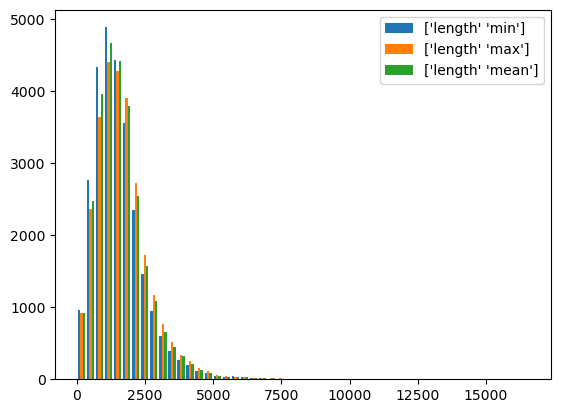

In [2]:
# File path
genome_file = "../datasets/Araport11_GFF3_genes_transposons.current_utf8_attributes.tsv.gz"

# Read the GFF file into a DataFrame (skip comment lines)
df = pd.read_csv(
    genome_file,
    sep="\t",
    comment="#",
    dtype={"start": int, "end": int},
    compression="gzip",
    usecols=[2, 3, 4, 8, 17], 
    index_col="ID"
)
# Lengths
df["length"] = df["end"] - df["start"] + 1

# Filter for genes (length is correct as is)
genes = df[df["feature"] == "gene"]

# For mRNAs, sum up the lengths of the exons
rnas = df[ (df["feature"] == "mRNA") & df["Parent"].isin(genes.index)]

exons = df[ (df["feature"] == "exon") & df["Parent"].isin(rnas.index)]
exons = exons.groupby("Parent").agg({
    "start":"min",
    "end":"max",
    "length":"sum"
})

rnas = rnas[["feature", "Parent"]].join(exons)
rnas.dropna(subset="length", inplace=True)

# select one RNA per gene
# plot if we use min / max / mean per gene
rnas_ = rnas.groupby('Parent').agg({'length': ['min', 'max', 'mean']})
ax = plt.hist(rnas_, bins=50, label=list(rnas_.columns))
plt.legend()
plt.title = "RNA lengths per parent gene"

# use the mean
rnas = rnas.groupby('Parent').agg({
    'feature':'first',
    'start':'first',
    'end':'first',
    'Parent':'first',
    'length': 'mean'
})

## Fit linear model (gene length --> RNA length)

In [3]:
# average ratio between gene and RNA length
rnas["gene_length"] = genes.loc[rnas["Parent"]]['length']

Linear model: RNA_length ≈ 0.6323 * gene_length + 0.00
R² score: 0.7466
Data points: 27537


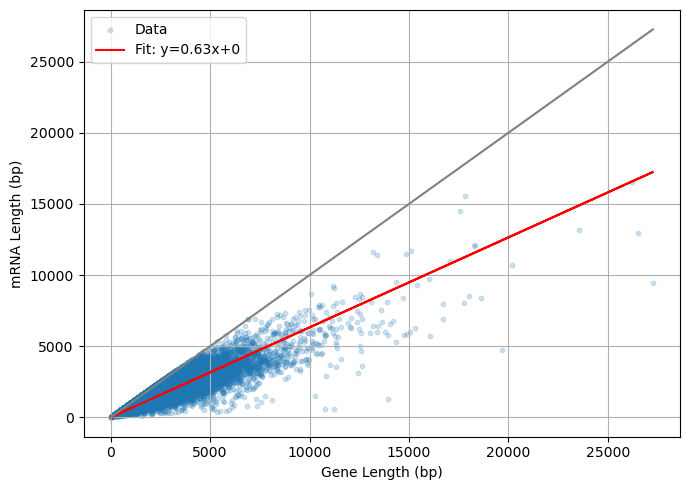

In [6]:
X = rnas[["gene_length"]]
y = rnas["length"]
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

r2 = model.score(X, y)
slope = model.coef_[0]
intercept = model.intercept_

# Print model summary
print(f"Linear model: RNA_length ≈ {slope:.4f} * gene_length + {intercept:.2f}")
print(f"R² score: {r2:.4f}")
print(f"Data points: {len(X)}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(X, y, alpha=0.2, label="Data", s=10)
plt.plot(X, model.predict(X), color="red", label=f"Fit: y={slope:.2f}x+{intercept:.0f}")

plt.plot([0, X['gene_length'].max()], [0, X['gene_length'].max()], linestyle="-", color="grey")
plt.xlabel("Gene Length (bp)")
plt.ylabel("mRNA Length (bp)")

plt.legend()
plt.tight_layout()
plt.grid(True)

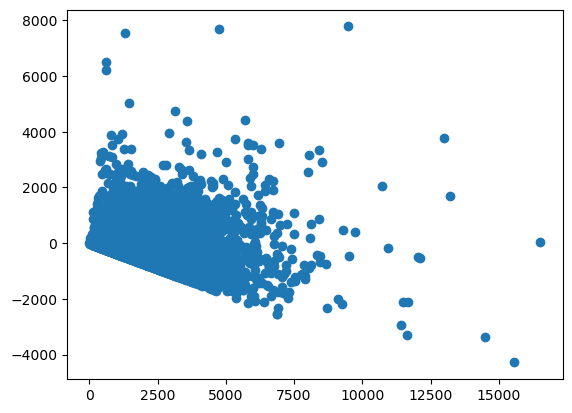

In [62]:
plt.plot(y, model.predict(X) -y, 'o')

In [6]:
def mrna_length(gene_length):
    return slope*gene_length + intercept

In [17]:
rnas.shape, genes.shape

((27537, 6), (33318, 5))

## Distribution of gene lengths

Gene count: 27537
Gene length (mean, median): 2380.5, 2075.0


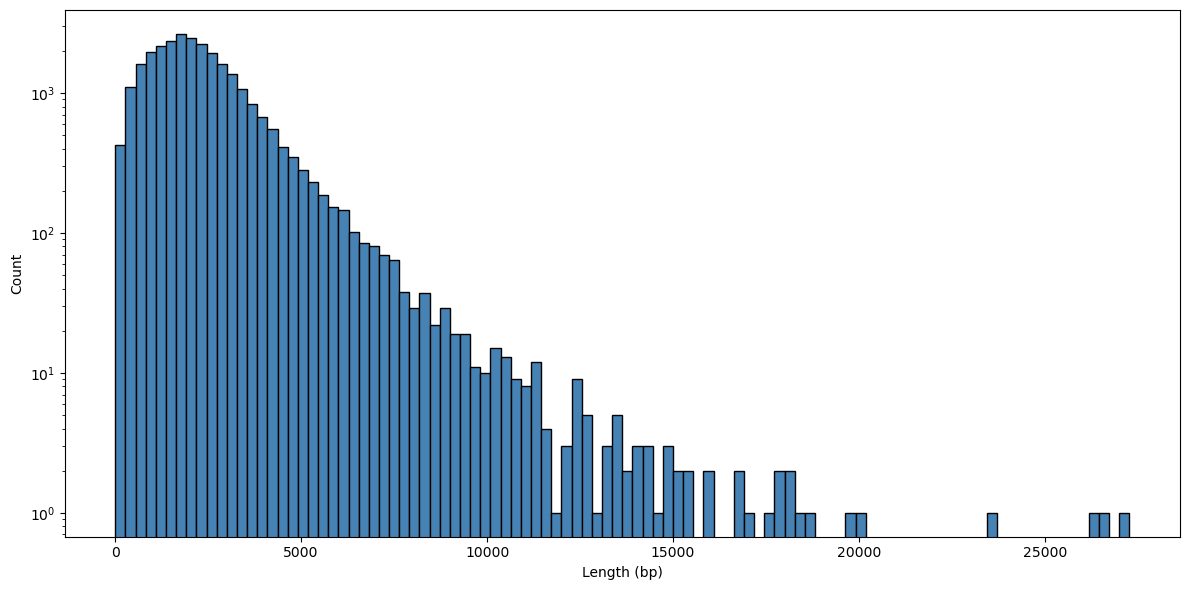

In [21]:
# Extract lengths
gene_lengths = rnas["gene_length"]

# # Summary
print(f"Gene count: {len(gene_lengths)}")
print(f"Gene length (mean, median): {gene_lengths.mean():.1f}, {gene_lengths.median()}")

# # Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.hist(gene_lengths, bins=100, color="steelblue", edgecolor="black")
# plt.title("Gene Length Distribution")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.yscale("log")

plt.tight_layout()
# plt.savefig("length_distributions.png")
plt.show()

In [22]:
data = gene_lengths

In [30]:
# !pip install fitter


2025-08-04 16:53:46.815 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-08-04 16:53:47.021 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=1e-06)
2025-08-04 16:53:47.191 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=1e-06)
2025-08-04 16:53:47.397 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=1e-06)
2025-08-04 16:53:47.632 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.0)
2025-08-04 16:53:47.660 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=2e-06)
2025-08-04 16:53:47.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.0)
2025-08-04 16:53:48.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribut

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,7.917393e-09,2079.234723,2112.110106,0.003847,0.007537,0.088360
mielke,8.462814e-09,2078.485690,2111.361073,0.004154,0.008830,0.027662
burr12,1.446555e-08,2088.964010,2121.839392,0.004847,0.015295,0.000005
gumbel_r,1.707076e-08,2118.683590,2135.121281,0.009500,0.015508,0.000004
genlogistic,1.717935e-08,2121.412114,2146.068651,0.009569,0.015688,0.000003


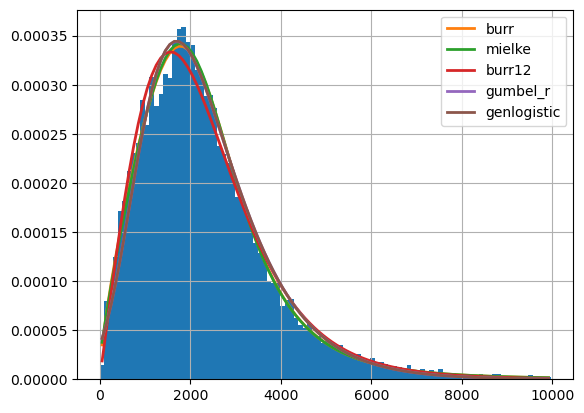

/home/cbleker/miniconda3/envs/python-env/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [65]:
from fitter import Fitter
f = Fitter(data, xmin=0, xmax=10000)
f.fit(max_workers=5)
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,7.917393e-09,2079.234723,2112.110106,0.003847,0.007537,0.088360
mielke,8.462814e-09,2078.485690,2111.361073,0.004154,0.008830,0.027662
burr12,1.446555e-08,2088.964010,2121.839392,0.004847,0.015295,0.000005
gumbel_r,1.707076e-08,2118.683590,2135.121281,0.009500,0.015508,0.000004
genlogistic,1.717935e-08,2121.412114,2146.068651,0.009569,0.015688,0.000003


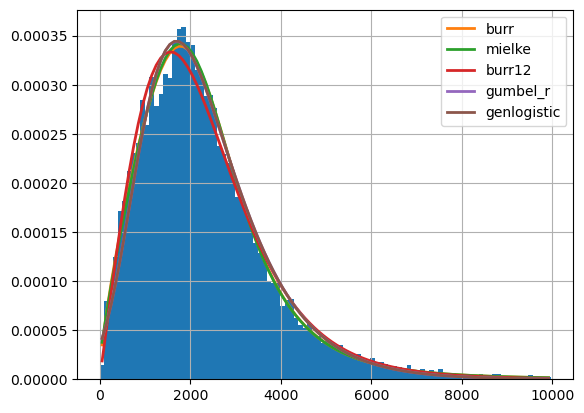

In [67]:
f.summary()

In [ ]:
# sample gene lengths from the selected distributions, then calculate the mRNA lengths using the linear model

In [35]:
f.get_best()

{'burr': {'c': 3.6194744209844654,
  'd': 0.49859394344631247,
  'loc': -16.802061284283596,
  'scale': 2838.486352394155}}